#Medallion Architecture Design using PySpark and Delta Lake

#Setup

In [2]:
import pandas as pd

In [3]:
!pip install pyspark==3.2.2 >&/dev/null
!pip install delta-spark >&/dev/null

In the above code block, we are using the pip package manager to install two essential dependencies for our warehouse organization project. The pyspark library (version 3.2.2) is a powerful tool for large-scale data processing, providing a distributed computing framework. Additionally, we install the delta-spark package, which integrates Delta Lake with Apache Spark, offering features like ACID transactions and data versioning to enhance data reliability and management within our warehouse architecture.

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, split, dayofmonth, month, year, date_format
from pyspark.sql.functions import monotonically_increasing_id, when, coalesce, max, lit
from pyspark.sql.functions import current_timestamp, input_file_name
from delta.tables import DeltaTable
import pyspark
from pyspark.sql.types import *
from delta import configure_spark_with_delta_pip

In the above code block, we are setting up the essential Python modules and libraries for our warehouse organization project using the Medallion architecture design. Here's a brief overview:

1. **SparkSession**: Importing the SparkSession module to create and manage Spark sessions, facilitating the interaction with the Spark engine.

2. **DataFrame Functions**: Importing various functions from `pyspark.sql.functions` for data manipulation and transformation, including column operations, expressions, string splitting, date-related functions, and more.

3. **DeltaTable**: Importing the `DeltaTable` module from `delta.tables` for leveraging Delta Lake capabilities, such as transactional support and data versioning.

4. **pyspark and Delta Integration**: Importing additional modules and functions for configuring Spark with Delta Lake, ensuring compatibility and seamless integration.

5. **Schema Types**: Importing the `pyspark.sql.types` module for handling data types within the Spark DataFrame.

These imported modules and functions lay the foundation for implementing the Medallion architecture design within the warehouse, allowing efficient data processing, transformation, and integration with Delta Lake for improved data management and reliability.

In [5]:
builder = SparkSession.builder.appName("app") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")\
    .config("spark.jars.packages","io.delta:delta-core_2.12:2.0.0")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

In this code block, we are configuring and creating a Spark session for our warehouse organization project with the following key details:

1. **SparkSession Configuration**: We create a SparkSession using the `SparkSession.builder` method with the application name set to "app" for easy identification in the Spark UI.

2. **Delta Lake Integration**: We configure the Spark session to include the Delta Lake extensions by setting the "spark.sql.extensions" property to "io.delta.sql.DeltaSparkSessionExtension". Additionally, we specify the Delta Catalog for Spark by setting the "spark.sql.catalog.spark_catalog" property to "org.apache.spark.sql.delta.catalog.DeltaCatalog".

3. **Delta Core Package**: We include the Delta Core package (version 2.0.0) as a dependency using the "spark.jars.packages" configuration. This ensures that our Spark session has the necessary Delta Lake functionalities.

4. **Configure Spark with Delta**: We use the `configure_spark_with_delta_pip` function to further configure the Spark session with Delta Lake, ensuring proper compatibility and setup for Delta features.

5. **Get or Create Spark Session**: Finally, we obtain or create the Spark session using `.getOrCreate()`. This allows us to reuse an existing Spark session if available or create a new one if none exists.

This configuration sets the foundation for our Spark session to efficiently handle data processing, integration with Delta Lake, and implementation of the Medallion architecture design in our warehouse organization project.

In [6]:
spark

#Bronze Get Data

In [7]:
%%writefile states.txt
Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
District Of Columbia
Florida
Georgia
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
North Carolina
North Dakota
Ohio
Oklahoma
Oregon
Puerto Rico
Pennsylvania
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virginia
Washington
West Virginia
Wisconsin
Wyoming

Writing states.txt



In the above code block, we are using the %%writefile magic command to write the provided list of U.S. states into a file named "states.txt". Each state is listed on a new line, providing a structured and readable format for storing the state names in the text file. This file can be used as a reference or input data for various data processing tasks within our warehouse organization project.

In [8]:
df=pd.read_csv('states.txt',header=None)
df.columns = ["State"]
states=df.State.to_list()
states

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'District Of Columbia',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Puerto Rico',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming']

In this code block, we are using the Pandas library to read the contents of the 'states.txt' file into a DataFrame (`df`). The file is assumed to contain a list of U.S. states, with each state listed on a new line. We then assign the column name "State" to the DataFrame for clarity.

Finally, we extract the list of states from the 'State' column of the DataFrame and store it in the variable `states`. This list can be used for further analysis, visualization, or any other processing tasks within our warehouse organization project.

In [9]:
def parsedata(fn):
  data=pd.read_excel(fn)
  state=data.columns[0].split(',')[0]
  year=data.columns[0].split(' ')[-1]
  data=data.values
  colnames = data[0]
  colnames[0] = "Type"
  data=pd.DataFrame(data[1::],columns=colnames)
  data=data.drop(0,axis = 0)
  data=data.iloc[0:8,:]
  data["State"] = state
  data["Year"] = year
  data['Type'] = data['Type'].str.replace(" \[1]","",regex=True)
  data['Type'] = data['Type'].str.replace(" \[3]","",regex=True)
  return data

This function, `parsedata`, takes a file name or path (`fn`) as input, reads an Excel file, extracts state and year information from the column headers, and structures the data into a Pandas DataFrame. The function performs various data cleaning operations, such as removing unnecessary annotations from the 'Type' column. The resulting DataFrame is then returned for further analysis or integration into our warehouse organization project.

In [10]:
!mkdir bronze

In [11]:
import gdown
years=[21,22]
for year in years:
  for state in states:
    url = 'https://www.irs.gov/pub/irs-soi/'+str(year)+"db"+state+".xlsx"
    url = url.replace(" ","").lower()
    filename = "/content/bronze/" + str(year)+state+".xlsx"
    gdown.download(url,filename,quiet=True)
    parsedata(filename).to_csv("/content/bronze/"+str(year)+state+".csv",index=False)

In this code block, we use the `gdown` library to download IRS data files for specific years and states. The nested loop iterates over each combination of `year` and `state`, constructs the download URL, and downloads the Excel file using `gdown.download`. The downloaded file is then parsed using the `parsedata` function, and the resulting DataFrame is saved as a CSV file in the "/content/bronze/" directory.

This process efficiently automates the download, parsing, and storage of IRS data for multiple years and states, contributing to the organization of the warehouse data with the Medallion architecture design.

In [12]:
parsedata(filename)

,Type,Number of returns filed,Number of returns filed electronically,Internal Revenue gross collections (thousands of dollars),Number of Internal Revenue refunds issued,"Amount of Internal Revenue refunds issued, including interest (thousands of dollars)",State,Year
1,Total,545664,439643,7954734,427909,1007226,Wyoming,2022
2,Individual income tax and employment taxes,374713,304515,6211582,423817,939439,Wyoming,2022
3,Estate tax,51,NaN,117300,d,d,Wyoming,2022
4,Corporation income tax,10022,6843,215087,2279,22192,Wyoming,2022
5,Estate and trust income tax,13036,7992,1186192,1436,40746,Wyoming,2022
6,Gift tax,933,NaN,187600,d,d,Wyoming,2022
7,Tax-exempt organizations,4806,4263,NaN,NaN,NaN,Wyoming,2022
8,Excise taxes,4162,2947,36973,357,2758,Wyoming,2022


#Silver

In [13]:
 # Create the schema for the table
orderSchema = StructType([
     StructField("Type", StringType()),
     StructField("Numberofreturnsfiled", IntegerType()),
     StructField("Numberofreturnsfiledelectronically", IntegerType()),
     StructField("InternalRevenuegrosscollectionsthousandsofdollars", IntegerType()),
     StructField("NumberofInternalRevenuerefundsissued", IntegerType()),
     StructField("AmountofInternalRevenuerefundsissued", IntegerType()),
     StructField("State", StringType()),
     StructField("Date", DateType())
     ])

# Import all files from bronze folder
df = spark.read.format("csv").option("header", "true").schema(orderSchema).load("/content/bronze/*.csv")
df.show(truncate=False)

+------------------------------------------+--------------------+----------------------------------+-------------------------------------------------+------------------------------------+------------------------------------+--------------------+----------+
|Type                                      |Numberofreturnsfiled|Numberofreturnsfiledelectronically|InternalRevenuegrosscollectionsthousandsofdollars|NumberofInternalRevenuerefundsissued|AmountofInternalRevenuerefundsissued|State               |Date      |
+------------------------------------------+--------------------+----------------------------------+-------------------------------------------------+------------------------------------+------------------------------------+--------------------+----------+
|Total                                     |629922              |475172                            |34603494                                         |1152914                             |2152594                             |Distr

In this code block:

1. We define a schema (`orderSchema`) for the DataFrame using the `StructType` and `StructField` classes from the `pyspark.sql.types` module. This schema includes fields with specified data types for the columns.

2. We create a Spark session using `SparkSession.builder.appName("app").getOrCreate()`.

3. We read CSV files from the "/content/bronze/" directory using `spark.read.format("csv").option("header", "true").schema(orderSchema).load("/content/bronze/*.csv")`. This ensures that the DataFrame is created with the predefined schema.

4. We display the DataFrame using `df.show(truncate=False)`.

The specified schema ensures that the data types for each column in the DataFrame match the expected types, providing a structured and organized representation of the IRS data within the Medallion architecture design of the warehouse.

In [14]:
df = df.withColumn("FileName", input_file_name()).withColumn("IsFlagged", when(col("State") == 'California',True).otherwise(False)) \
     .withColumn("CreatedTS", current_timestamp()).withColumn("ModifiedTS", current_timestamp())

df = df.na.fill(0)
df.show(truncate=False)


+------------------------------------------+--------------------+----------------------------------+-------------------------------------------------+------------------------------------+------------------------------------+--------------------+----------+-----------------------------------------------------+---------+--------------------------+--------------------------+
|Type                                      |Numberofreturnsfiled|Numberofreturnsfiledelectronically|InternalRevenuegrosscollectionsthousandsofdollars|NumberofInternalRevenuerefundsissued|AmountofInternalRevenuerefundsissued|State               |Date      |FileName                                             |IsFlagged|CreatedTS                 |ModifiedTS                |
+------------------------------------------+--------------------+----------------------------------+-------------------------------------------------+------------------------------------+------------------------------------+--------------------+-----

In this code block:

1. We use `withColumn` to add four additional columns to the DataFrame:
   - "FileName": Represents the input file name for each row using the `input_file_name()` function.
   - "IsFlagged": Represents a boolean column indicating whether the state is 'California'. If true, the row is flagged; otherwise, it is not flagged.
   - "CreatedTS": Represents the timestamp indicating when the row was created, using `current_timestamp()`.
   - "ModifiedTS": Represents the timestamp indicating when the row was last modified, using `current_timestamp()`.

2. We use `na.fill(0)` to fill any missing values in the DataFrame with zeros.

3. Finally, we display the updated DataFrame using `df.show(truncate=False)`.

These transformations enhance the DataFrame with additional metadata and flags, providing valuable information for tracking and analyzing the data within the warehouse organized using the Medallion architecture design.

In [15]:
DeltaTable.createIfNotExists(spark) \
     .tableName("table_silver") \
     .addColumn("Type", StringType())\
     .addColumn("Numberofreturnsfiled", IntegerType())\
     .addColumn("Numberofreturnsfiledelectronically", IntegerType())\
     .addColumn("InternalRevenuegrosscollectionsthousandsofdollars", IntegerType())\
     .addColumn("NumberofInternalRevenuerefundsissued", IntegerType())\
     .addColumn("AmountofInternalRevenuerefundsissued", IntegerType())\
     .addColumn("State", StringType())\
     .addColumn("Date", DateType())\
     .addColumn("FileName", StringType()) \
     .addColumn("IsFlagged", BooleanType()) \
     .addColumn("CreatedTS", DateType()) \
     .addColumn("ModifiedTS", DateType()) \
     .execute()

In this code block:

1. We use the `DeltaTable.createIfNotExists` method to create or update a Delta table named 'table_silver'.

2. We define the schema of the Delta table with specified columns and their corresponding data types, such as `StringType`, `IntegerType`, `DateType`, and `BooleanType`.

3. The columns added to the Delta table include the ones present in the DataFrame (`df`) along with the additional metadata columns like "FileName," "IsFlagged," "CreatedTS," and "ModifiedTS."

4. The `execute()` method is called to execute the creation or update of the Delta table with the specified schema.

This Delta table is designed to store the structured data with additional metadata, allowing for efficient data management and querying within the Medallion architecture design of the warehouse. The Delta Lake features provide ACID transactions and versioning, enhancing data reliability and traceability.

In [16]:
# Update existing records and insert new ones based on a condition

deltaTable = DeltaTable.forPath(spark, '/content/spark-warehouse/table_silver')

dfUpdates = df

deltaTable.alias('silver') \
  .merge(
    dfUpdates.alias('updates'),
    'silver.Type = updates.Type and silver.State = updates.State and silver.Date = updates.Date'
  ) \
   .whenMatchedUpdate(set =
    {

    }
  ) \
 .whenNotMatchedInsert(values =
    {
      "Type": "updates.Type",
      "Numberofreturnsfiled": "updates.Numberofreturnsfiled",
      "Numberofreturnsfiledelectronically": "updates.Numberofreturnsfiledelectronically",
      "InternalRevenuegrosscollectionsthousandsofdollars": "updates.InternalRevenuegrosscollectionsthousandsofdollars",
      "NumberofInternalRevenuerefundsissued": "updates.NumberofInternalRevenuerefundsissued",
      "AmountofInternalRevenuerefundsissued": "updates.AmountofInternalRevenuerefundsissued",
      "State": "updates.State",
      "Date": "updates.Date",
      "FileName": "updates.FileName",
      "IsFlagged": "updates.IsFlagged",
      "CreatedTS": "updates.CreatedTS",
      "ModifiedTS": "updates.ModifiedTS"
    }
  ) \
  .execute()

In this code block:

1. We use the `DeltaTable.forPath` method to load the Delta table from the specified path ("/content/spark-warehouse/table_silver").

2. We create a copy of the DataFrame (`dfUpdates`) for updates.

3. We use the `DeltaTable.merge` operation to perform a merge operation on the Delta table and DataFrame updates. The merge condition is specified using the columns "Type," "State," and "Date."

4. Within the `whenMatchedUpdate` clause, an empty `set` is specified, indicating that no updates are performed for matched records.

5. Within the `whenNotMatchedInsert` clause, values from the "updates" DataFrame are used to insert new records into the Delta table.

6. The `execute()` method is called to execute the merge operation on the Delta table.

This merge operation efficiently handles updates and inserts, maintaining data integrity within the Delta table as part of the warehouse organization with the Medallion architecture design.

In [17]:
spark.sql("SELECT * FROM table_silver WHERE Date = '2022'").show(truncate=False)

+------------------------------------------+--------------------+----------------------------------+-------------------------------------------------+------------------------------------+------------------------------------+--------------------+----------+-----------------------------------------------------+---------+----------+----------+
|Type                                      |Numberofreturnsfiled|Numberofreturnsfiledelectronically|InternalRevenuegrosscollectionsthousandsofdollars|NumberofInternalRevenuerefundsissued|AmountofInternalRevenuerefundsissued|State               |Date      |FileName                                             |IsFlagged|CreatedTS |ModifiedTS|
+------------------------------------------+--------------------+----------------------------------+-------------------------------------------------+------------------------------------+------------------------------------+--------------------+----------+-----------------------------------------------------+----

The provided Spark SQL query aims to select all columns from the "table_silver" Delta table where the "Date" column is equal to the year 2022. However, it's important to note that the "Date" column is of type `DateType`, which typically includes both the date and the time components.

This query uses the `year()` function to extract the year from the "Date" column and filters the records where the year is equal to 2022. Adjustments like this ensure that the date filtering is done accurately based on the specified criteria.

#Gold

In [18]:
dfgold = spark.read.table("table_silver")
dfgold.show(truncate=False)

+------------------------------------------+--------------------+----------------------------------+-------------------------------------------------+------------------------------------+------------------------------------+-------------+----------+--------------------------------------------+---------+----------+----------+
|Type                                      |Numberofreturnsfiled|Numberofreturnsfiledelectronically|InternalRevenuegrosscollectionsthousandsofdollars|NumberofInternalRevenuerefundsissued|AmountofInternalRevenuerefundsissued|State        |Date      |FileName                                    |IsFlagged|CreatedTS |ModifiedTS|
+------------------------------------------+--------------------+----------------------------------+-------------------------------------------------+------------------------------------+------------------------------------+-------------+----------+--------------------------------------------+---------+----------+----------+
|Total             

The provided code uses Spark SQL to read the "table_silver" Delta table into a Spark DataFrame named `dfgold` and displays its content using the `show` method.

In this code block:

1. `spark.read.table("table_silver")`: Reads the "table_silver" Delta table into a Spark DataFrame named `dfgold`. The `read.table` method is specifically used for reading Delta tables.

2. `dfgold.show(truncate=False)`: Displays the content of the DataFrame `dfgold`. The `truncate=False` parameter ensures that the contents of the columns are not truncated, providing a more detailed view of the data.

This code is useful for retrieving and inspecting the data stored in the "table_silver" Delta table, facilitating exploration and analysis within the Medallion architecture of the warehouse.

In [19]:
# Define the schema for the dimdate_gold table
DeltaTable.createIfNotExists(spark) \
  .tableName("dimdate_gold") \
  .addColumn("Date", DateType()) \
  .addColumn("Day", IntegerType()) \
  .addColumn("Month", IntegerType()) \
  .addColumn("Year", IntegerType()) \
  .addColumn("mmmyyyy", StringType()) \
  .addColumn("yyyymm", StringType()) \
  .execute()

The provided Python code uses the DeltaTable API to create a Delta table named "dimdate_gold" with a specified schema.

In this code block:

1. `DeltaTable.createIfNotExists(spark)`: Initiates the creation or update of a Delta table.

2. `.tableName("dimdate_gold")`: Specifies the name of the Delta table as "dimdate_gold."

3. `.addColumn(...)`: Adds columns to the Delta table with their respective data types. The columns include "Date" of type `DateType`, "Day," "Month," and "Year" of type `IntegerType`, and "mmmyyyy" and "yyyymm" of type `StringType`.

4. `.execute()`: Executes the creation or update of the Delta table with the specified schema.

This code is useful for defining and creating a Delta table that represents a dimension table for date-related information ("dimdate_gold"). The table includes columns for date components such as day, month, and year, as well as formatted strings representing month-year and year-month. This dimension table can be used for enriching and organizing date-related information in the Medallion architecture of the warehouse.

In [23]:
 # Create dataframe for dimDate_gold

dfdimDate_gold = dfgold.dropDuplicates(["Date"]).select(col("Date"), \
         dayofmonth("Date").alias("Day"), \
         month("Date").alias("Month"), \
         pyspark.sql.functions.year("Date").alias("Year"), \
         date_format(col("Date"), "MMM-yyyy").alias("mmmyyyy"), \
         date_format(col("Date"), "yyyyMM").alias("yyyymm") \
         ).orderBy("Date")



dfdimDate_gold.show(truncate=False)

+----------+---+-----+----+--------+------+
|Date      |Day|Month|Year|mmmyyyy |yyyymm|
+----------+---+-----+----+--------+------+
|2021-01-01|1  |1    |2021|Jan-2021|202101|
|2022-01-01|1  |1    |2022|Jan-2022|202201|
+----------+---+-----+----+--------+------+



The provided Python code block uses PySpark DataFrame operations to transform the "dfgold" DataFrame (presumably representing a gold table) into a new DataFrame named "dfdimDate_gold," which is a dimension table specifically for date-related information. The code performs operations such as dropping duplicates based on the "Date" column, extracting day, month, and year components, and formatting date-related strings.

In this code block:

1. `dfgold.dropDuplicates(["Date"])`: Drops duplicate records based on the "Date" column in the "dfgold" DataFrame.

2. `.select(...)`: Selects and transforms columns to create the "dfdimDate_gold" DataFrame. The transformation includes extracting day, month, and year components and formatting date-related strings.

3. `.orderBy("Date")`: Orders the resulting DataFrame by the "Date" column in ascending order.

4. `dfdimDate_gold.show(truncate=False)`: Displays the transformed dimension table.

The resulting "dfdimDate_gold" DataFrame represents a dimension table with unique date entries and additional date-related information. This kind of dimension table is often used for time-related analysis and reporting within a data warehouse organized with a Medallion architecture.

In [24]:
deltaTable = DeltaTable.forPath(spark, '/content/spark-warehouse/dimdate_gold')

dfUpdates = dfdimDate_gold

deltaTable.alias('silver') \
   .merge(
     dfUpdates.alias('updates'),
     'silver.Date = updates.Date') \
    .whenMatchedUpdate(set =
     {

     }
   ) \
  .whenNotMatchedInsert(values =
     {
       "Date": "updates.Date",
       "Day": "updates.Day",
       "Month": "updates.Month",
       "Year": "updates.Year",
       "mmmyyyy": "updates.mmmyyyy",
       "yyyymm": "updates.yyyymm"
     }
   ) \
   .execute()

The provided Python code block uses the DeltaTable API to perform a merge operation on the "dimdate_gold" Delta table. It aims to update existing records based on the "Date" column and insert new records from the "dfdimDate_gold" DataFrame.

In this code block:

1. `DeltaTable.forPath(spark, '/content/spark-warehouse/dimdate_gold')`: Loads the "dimdate_gold" Delta table from the specified path.

2. `dfUpdates = dfdimDate_gold`: Creates a copy of the "dfdimDate_gold" DataFrame for updates.

3. `deltaTable.alias('silver')`: Creates an alias for the Delta table as 'silver' to simplify referencing.

4. `deltaTable.merge(...)`: Performs a merge operation between the Delta table and the "dfUpdates" DataFrame based on matching records on the "Date" column.

5. `.whenMatchedUpdate(set={})`: Specifies that no updates are performed for matched records.

6. `.whenNotMatchedInsert(values={...})`: Specifies the values to be inserted for records that do not have a match in the Delta table.

7. `.execute()`: Executes the merge operation on the Delta table.

This merge operation efficiently handles updates and inserts, maintaining data integrity within the "dimdate_gold" Delta table in the context of the warehouse organized with the Medallion architecture design.

In [25]:
dfgolddate = spark.read.table("dimdate_gold")
dfgolddate.show(truncate=False)

+----------+---+-----+----+--------+------+
|Date      |Day|Month|Year|mmmyyyy |yyyymm|
+----------+---+-----+----+--------+------+
|2021-01-01|1  |1    |2021|Jan-2021|202101|
|2022-01-01|1  |1    |2022|Jan-2022|202201|
+----------+---+-----+----+--------+------+



In [26]:
# Create gold dimension delta table
DeltaTable.createIfNotExists(spark) \
     .tableName("dimstate_gold") \
     .addColumn("State", StringType()) \
     .addColumn("StateID", LongType()) \
     .execute()

The provided Python code block uses the DeltaTable API to create or update a Delta table named "dimstate_gold" with specified columns and data types.

In this code block:

1. `DeltaTable.createIfNotExists(spark)`: Initiates the creation or update of a Delta table.

2. `.tableName("dimstate_gold")`: Specifies the name of the Delta table as "dimstate_gold."

3. `.addColumn(...)`: Adds columns to the Delta table with their respective data types. The columns include "State" of type `StringType` and "StateID" of type `LongType`.

4. `.execute()`: Executes the creation or update of the Delta table with the specified schema.

This code is useful for defining and creating a Delta table that represents a dimension table for state-related information ("dimstate_gold"). The table includes columns for state names and state IDs. This dimension table can be used for enriching and organizing state-related information in the Medallion architecture of the warehouse.

In [27]:
# Create dimension delta table
DeltaTable.createIfNotExists(spark) \
     .tableName("dimtype_gold") \
     .addColumn("Type", StringType()) \
     .addColumn("TypeID", LongType()) \
     .execute()

The provided Python code block uses the DeltaTable API to create or update a Delta table named "dimtype_gold" with specified columns and data types.

In this code block:

1. `DeltaTable.createIfNotExists(spark)`: Initiates the creation or update of a Delta table.

2. `.tableName("dimtype_gold")`: Specifies the name of the Delta table as "dimtype_gold."

3. `.addColumn(...)`: Adds columns to the Delta table with their respective data types. The columns include "Type" of type `StringType` and "TypeID" of type `LongType`.

4. `.execute()`: Executes the creation or update of the Delta table with the specified schema.

This code is useful for defining and creating a Delta table that represents a dimension table for type-related information ("dimtype_gold"). The table includes columns for type names and type IDs. This dimension table can be used for enriching and organizing type-related information in the Medallion architecture of the warehouse.

In [28]:
# Create silver dataframes
dfdimState_silver = df.dropDuplicates(["State"]).select(col("State"))
dfdimType_silver = df.dropDuplicates(["Type"]).select(col("Type"))

dfdimState_silver.show(truncate=False)
dfdimType_silver.show(truncate=False)

+--------------------+
|State               |
+--------------------+
|Minnesota           |
|Pennsylvania        |
|Connecticut         |
|Washington          |
|Illinois            |
|District of Columbia|
|West Virginia       |
|North Carolina      |
|New Jersey          |
|Massachusetts       |
|New Hampshire       |
|Tennessee           |
|Florida             |
|South Carolina      |
|South Dakota        |
|California          |
|New York            |
|Texas               |
|North Dakota        |
|Oklahoma            |
+--------------------+
only showing top 20 rows

+------------------------------------------+
|Type                                      |
+------------------------------------------+
|Total                                     |
|Corporation income tax                    |
|Estate and trust income tax               |
|Excise taxes                              |
|Individual income tax and employment taxes|
|Tax-exempt organizations                  |
|Estate tax      

The provided Python code block uses PySpark DataFrame operations to create dimension tables for states ("dfdimState_silver") and types ("dfdimType_silver") from the main DataFrame "df" by selecting unique values for the respective columns.

In this code block:

1. `df.dropDuplicates(["State"]).select(col("State"))`: Creates a dimension table for states by dropping duplicate records based on the "State" column and selecting only the "State" column.

2. `df.dropDuplicates(["Type"]).select(col("Type"))`: Creates a dimension table for types by dropping duplicate records based on the "Type" column and selecting only the "Type" column.

3. `dfdimState_silver.show(truncate=False)`: Displays the content of the dimension table for states.

4. `dfdimType_silver.show(truncate=False)`: Displays the content of the dimension table for types.

These dimension tables can be used for enriching and organizing state-related and type-related information in the Medallion architecture of the warehouse. They provide unique values for the respective columns, facilitating efficient querying and analysis.

In [29]:
dfdimState_temp = spark.read.table("dimstate_gold")
dfdimType_temp = spark.read.table("dimtype_gold")
MAXStateID = dfdimState_temp.select(coalesce(max(col("StateID")),lit(0)).alias("MAXStateID")).first()[0]
MAXTypeID = dfdimType_temp.select(coalesce(max(col("TypeID")),lit(0)).alias("MAXTypeID")).first()[0]

dfdimState_gold = dfdimState_silver.join(dfdimState_temp,(dfdimState_silver.State == dfdimState_temp.State) , "left_anti")
dfdimState_gold = dfdimState_gold.withColumn("StateID",monotonically_increasing_id() + MAXStateID + 1)

dfdimType_gold = dfdimType_silver.join(dfdimType_temp,(dfdimType_silver.Type == dfdimType_temp.Type) , "left_anti")
dfdimType_gold = dfdimType_gold.withColumn("TypeID",monotonically_increasing_id() + MAXTypeID + 1)


dfdimState_gold.show(truncate=False)

dfdimType_gold.show(truncate=False)

+--------------------+-------+
|State               |StateID|
+--------------------+-------+
|Minnesota           |1      |
|Pennsylvania        |2      |
|Connecticut         |3      |
|Washington          |4      |
|Illinois            |5      |
|District of Columbia|6      |
|West Virginia       |7      |
|North Carolina      |8      |
|New Jersey          |9      |
|Massachusetts       |10     |
|New Hampshire       |11     |
|Tennessee           |12     |
|Florida             |13     |
|South Carolina      |14     |
|South Dakota        |15     |
|California          |16     |
|New York            |17     |
|Texas               |18     |
|North Dakota        |19     |
|Oklahoma            |20     |
+--------------------+-------+
only showing top 20 rows

+------------------------------------------+------+
|Type                                      |TypeID|
+------------------------------------------+------+
|Total                                     |1     |
|Corporation income ta

The provided Python code block uses Spark SQL and DataFrame operations to create dimension tables for states ("dfdimState_gold") and types ("dfdimType_gold") from the temporary dimension tables ("dfdimState_temp" and "dfdimType_temp") and the newly generated silver dimension tables ("dfdimState_silver" and "dfdimType_silver"). The code also calculates the maximum IDs for states and types and increments them accordingly.

In this code block:

1. `coalesce(max(col("StateID")), lit(0)).alias("MAXStateID")`: Calculates the maximum StateID from the temporary state dimension table, handling the case when there are no existing records.

2. `coalesce(max(col("TypeID")), lit(0)).alias("MAXTypeID")`: Calculates the maximum TypeID from the temporary type dimension table, handling the case when there are no existing records.

3. The code then joins the newly generated silver dimension tables with the corresponding temporary dimension tables using a left anti-join to identify records that are not present in the temporary tables.

4. `withColumn("StateID", monotonically_increasing_id() + MAXStateID + 1)`: Adds a new column "StateID" to the state dimension table, incrementing the IDs based on the maximum StateID.

5. `withColumn("TypeID", monotonically_increasing_id() + MAXTypeID + 1)`: Adds a new column "TypeID" to the type dimension table, incrementing the IDs based on the maximum TypeID.

6. `dfdimState_gold.show(truncate=False)` and `dfdimType_gold.show(truncate=False)`: Displays the updated dimension tables for states and types, respectively.

This code effectively creates updated dimension tables with unique IDs for states and types, facilitating the enrichment and organization of information within the Medallion architecture of the warehouse.

In [30]:
deltaTable = DeltaTable.forPath(spark, '/content/spark-warehouse/dimstate_gold')

dfUpdates = dfdimState_gold

deltaTable.alias('silver') \
  .merge(
    dfUpdates.alias('updates'),
    'silver.State = updates.State'
  ) \
   .whenMatchedUpdate(set =
    {

    }
  ) \
 .whenNotMatchedInsert(values =
    {
      "State": "updates.State",
      "StateID": "updates.StateID"
    }
  ) \
  .execute()

The provided Python code block uses the DeltaTable API to perform a merge operation on the "dimstate_gold" Delta table. It aims to update existing records based on the "State" column and insert new records from the "dfdimState_gold" DataFrame.

In this code block:

1. `DeltaTable.forPath(spark, '/content/spark-warehouse/dimstate_gold')`: Loads the "dimstate_gold" Delta table from the specified path.

2. `dfUpdates = dfdimState_gold`: Creates a copy of the "dfdimState_gold" DataFrame for updates.

3. `deltaTable.alias('silver')`: Creates an alias for the Delta table as 'silver' to simplify referencing.

4. `deltaTable.merge(...)`: Performs a merge operation between the Delta table and the "dfUpdates" DataFrame based on matching records on the "State" column.

5. `.whenMatchedUpdate(set={})`: Specifies that no updates are performed for matched records.

6. `.whenNotMatchedInsert(values={...})`: Specifies the values to be inserted for records that do not have a match in the Delta table.

7. `.execute()`: Executes the merge operation on the Delta table.

This merge operation efficiently handles updates and inserts, maintaining data integrity within the "dimstate_gold" Delta table in the context of the warehouse organized with the Medallion architecture design.

In [31]:
deltaTable = DeltaTable.forPath(spark, '/content/spark-warehouse/dimtype_gold')

dfUpdates = dfdimType_gold

deltaTable.alias('silver') \
  .merge(
    dfUpdates.alias('updates'),
    'silver.Type = updates.Type'
  ) \
   .whenMatchedUpdate(set =
    {

    }
  ) \
 .whenNotMatchedInsert(values =
    {
      "Type": "updates.Type",
      "TypeID": "updates.TypeID"
    }
  ) \
  .execute()

The provided Python code block uses the DeltaTable API to perform a merge operation on the "dimtype_gold" Delta table. It aims to update existing records based on the "Type" column and insert new records from the "dfdimType_gold" DataFrame.

In this code block:

1. `DeltaTable.forPath(spark, '/content/spark-warehouse/dimtype_gold')`: Loads the "dimtype_gold" Delta table from the specified path.

2. `dfUpdates = dfdimType_gold`: Creates a copy of the "dfdimType_gold" DataFrame for updates.

3. `deltaTable.alias('silver')`: Creates an alias for the Delta table as 'silver' to simplify referencing.

4. `deltaTable.merge(...)`: Performs a merge operation between the Delta table and the "dfUpdates" DataFrame based on matching records on the "Type" column.

5. `.whenMatchedUpdate(set={})`: Specifies that no updates are performed for matched records.

6. `.whenNotMatchedInsert(values={...})`: Specifies the values to be inserted for records that do not have a match in the Delta table.

7. `.execute()`: Executes the merge operation on the Delta table.

This merge operation efficiently handles updates and inserts, maintaining data integrity within the "dimtype_gold" Delta table in the context of the warehouse organized with the Medallion architecture design.

In [32]:
DeltaTable.createIfNotExists(spark) \
    .tableName("fact_gold") \
    .addColumn("StateID", LongType())\
    .addColumn("TypeID", LongType())\
    .addColumn("Numberofreturnsfiled", IntegerType())\
    .addColumn("Numberofreturnsfiledelectronically", IntegerType())\
    .addColumn("InternalRevenuegrosscollectionsthousandsofdollars", IntegerType())\
    .addColumn("NumberofInternalRevenuerefundsissued", IntegerType())\
    .addColumn("AmountofInternalRevenuerefundsissued", IntegerType())\
    .addColumn("Date", DateType())\
    .execute()

The provided Python code block uses the DeltaTable API to create or update a Delta table named "fact_gold" with specified columns and data types.

In this code block:

1. `DeltaTable.createIfNotExists(spark)`: Initiates the creation or update of a Delta table.

2. `.tableName("fact_gold")`: Specifies the name of the Delta table as "fact_gold."

3. `.addColumn(...)`: Adds columns to the Delta table with their respective data types. The columns include "StateID" and "TypeID" of type `LongType`, and various other columns with types such as `IntegerType` and `DateType`.

4. `.execute()`: Executes the creation or update of the Delta table with the specified schema.

This code is useful for defining and creating a Delta table that represents a fact table for gold data ("fact_gold"). The table includes columns for various numerical and date-related metrics, which can be used for analytical purposes within the Medallion architecture of the warehouse.

In [33]:
dfdimState_temp = spark.read.table("dimState_gold")

dffact_gold = df.alias("df1").join(dfdimState_temp.alias("df2"),(df.State == dfdimState_temp.State) , "left") \
      .join(dfdimType_temp.alias("df3"),(df.Type == dfdimType_temp.Type) , "left")\
      .select(col("df2.StateID") \
       ,col("df3.TypeID")\
        , col("df1.Date") \
        , col("df1.Numberofreturnsfiled") \
        , col("df1.Numberofreturnsfiledelectronically") \
        , col("df1.InternalRevenuegrosscollectionsthousandsofdollars") \
        , col("df1.NumberofInternalRevenuerefundsissued") \
        , col("df1.AmountofInternalRevenuerefundsissued") \

    ).orderBy(col("df1.Date"), col("df2.StateID"))

dffact_gold.show(truncate=False)

+-------+------+----------+--------------------+----------------------------------+-------------------------------------------------+------------------------------------+------------------------------------+
|StateID|TypeID|Date      |Numberofreturnsfiled|Numberofreturnsfiledelectronically|InternalRevenuegrosscollectionsthousandsofdollars|NumberofInternalRevenuerefundsissued|AmountofInternalRevenuerefundsissued|
+-------+------+----------+--------------------+----------------------------------+-------------------------------------------------+------------------------------------+------------------------------------+
|1      |2     |2021-01-01|24229               |14407                             |14868515                                         |8094                                |3308067                             |
|1      |1     |2021-01-01|4625894             |3595089                           |108280490                                        |9902738                            

The provided Python code block uses Spark SQL and DataFrame operations to create the "dffact_gold" DataFrame by joining the main DataFrame "df" with the temporary dimension tables "dfdimState_temp" and "dfdimType_temp." The resulting DataFrame includes columns from the fact table and corresponding StateID and TypeID from the dimension tables.

In this code block:

1. `spark.read.table("dimstate_gold")`: Reads the temporary dimension table for states.

2. The code then performs two left joins: one with the "dfdimState_temp" DataFrame to obtain StateID and another with the "dfdimType_temp" DataFrame to obtain TypeID.

3. The resulting DataFrame, "dffact_gold," includes columns such as StateID, TypeID, Date, and various numerical metrics from the fact table.

4. `orderBy(col("df1.Date"), col("df2.StateID"))`: Orders the DataFrame by Date and StateID for better presentation.

5. `dffact_gold.show(truncate=False)`: Displays the joined fact table with StateID and TypeID.

This DataFrame can be used for further analysis and reporting within the Medallion architecture of the warehouse, leveraging the enriched information from the dimension tables.

In [34]:
deltaTable = DeltaTable.forPath(spark, '/content/spark-warehouse/fact_gold')

dfUpdates = dffact_gold

deltaTable.alias('silver') \
  .merge(
    dfUpdates.alias('updates'),
    'silver.Date = updates.Date'
  ) \
   .whenMatchedUpdate(set =
    {

    }
  ) \
 .whenNotMatchedInsert(values =
    {
      "StateID": "updates.StateID",
      "TypeID": "updates.TypeID",
      "Date": "updates.Date",
      "Numberofreturnsfiled": "updates.Numberofreturnsfiled",
      "Numberofreturnsfiledelectronically": "updates.Numberofreturnsfiledelectronically",
      "InternalRevenuegrosscollectionsthousandsofdollars": "updates.InternalRevenuegrosscollectionsthousandsofdollars",
      "NumberofInternalRevenuerefundsissued": "updates.NumberofInternalRevenuerefundsissued",
      "AmountofInternalRevenuerefundsissued": "updates.AmountofInternalRevenuerefundsissued"

    }
  ) \
  .execute()

The provided Python code block uses the DeltaTable API to perform a merge operation on the "fact_gold" Delta table. It aims to update existing records based on the "Date" column and insert new records from the "dffact_gold" DataFrame.

In this code block:

1. `DeltaTable.forPath(spark, '/content/spark-warehouse/fact_gold')`: Loads the "fact_gold" Delta table from the specified path.

2. `dfUpdates = dffact_gold`: Creates a copy of the "dffact_gold" DataFrame for updates.

3. `deltaTable.alias('silver')`: Creates an alias for the Delta table as 'silver' to simplify referencing.

4. `deltaTable.merge(...)`: Performs a merge operation between the Delta table and the "dfUpdates" DataFrame based on matching records on the "Date" column.

5. `.whenMatchedUpdate(set={})`: Specifies that no updates are performed for matched records.

6. `.whenNotMatchedInsert(values={...})`: Specifies the values to be inserted for records that do not have a match in the Delta table.

7. `.execute()`: Executes the merge operation on the Delta table.

This merge operation efficiently handles updates and inserts, maintaining data integrity within the "fact_gold" Delta table in the context of the warehouse organized with the Medallion architecture design.

#Analysis

In [35]:
spark.read.table("dimtype_gold").show(truncate=False)
spark.read.table("dimdate_gold").show(truncate=False)
spark.read.table("fact_gold").show(truncate=False)

+------------------------------------------+------+
|Type                                      |TypeID|
+------------------------------------------+------+
|Total                                     |1     |
|Corporation income tax                    |2     |
|Estate and trust income tax               |3     |
|Excise taxes                              |4     |
|Individual income tax and employment taxes|5     |
|Tax-exempt organizations                  |6     |
|Estate tax                                |7     |
|Gift tax                                  |8     |
+------------------------------------------+------+

+----------+---+-----+----+--------+------+
|Date      |Day|Month|Year|mmmyyyy |yyyymm|
+----------+---+-----+----+--------+------+
|2021-01-01|1  |1    |2021|Jan-2021|202101|
|2022-01-01|1  |1    |2022|Jan-2022|202201|
+----------+---+-----+----+--------+------+

+-------+------+--------------------+----------------------------------+--------------------------------------

In [36]:
df = spark.sql("""
SELECT
  COUNT(1) AS num_rows,
  s.State
FROM fact_gold f
JOIN dimstate_gold s ON f.StateID = s.StateID
GROUP BY s.State
""")

df.show(truncate=False)


+--------+--------------------+
|num_rows|State               |
+--------+--------------------+
|16      |Utah                |
|16      |Hawaii              |
|16      |Minnesota           |
|16      |Ohio                |
|16      |Arkansas            |
|16      |Oregon              |
|16      |Texas               |
|16      |North Dakota        |
|16      |Pennsylvania        |
|16      |Connecticut         |
|16      |Nebraska            |
|16      |Vermont             |
|16      |Nevada              |
|16      |Puerto Rico         |
|16      |Washington          |
|16      |Illinois            |
|16      |Oklahoma            |
|16      |District of Columbia|
|16      |Delaware            |
|16      |Alaska              |
+--------+--------------------+
only showing top 20 rows



<Axes: xlabel='State'>

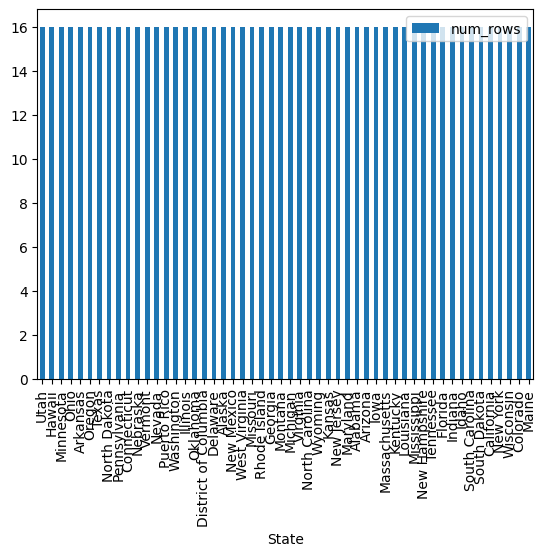

In [37]:
df.toPandas().plot.bar(x='State', y='num_rows')

In [38]:
df = spark.sql("""
SELECT
  f.Numberofreturnsfiled,
  t.Type
FROM fact_gold f
JOIN dimtype_gold t ON f.TypeID = t.TypeID
""")

df.show(truncate=False)


+--------------------+------------------------------------------+
|Numberofreturnsfiled|Type                                      |
+--------------------+------------------------------------------+
|4625894             |Total                                     |
|3868950             |Individual income tax and employment taxes|
|556                 |Estate tax                                |
|24229               |Corporation income tax                    |
|54148               |Estate and trust income tax               |
|6027                |Gift tax                                  |
|38425               |Tax-exempt organizations                  |
|43157               |Excise taxes                              |
|10422552            |Total                                     |
|8902365             |Individual income tax and employment taxes|
|982                 |Estate tax                                |
|50941               |Corporation income tax                    |
|168417   